In [165]:
from pathlib import Path
from sqlalchemy import create_engine, text
from sqlalchemy.ext.automap import automap_base
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np

database_path = "sqlite:///archive/revenue.sqlite"

In [57]:
engine = create_engine(database_path)
conn= engine.connect()

In [58]:
query=("SELECT * FROM revenue_data")

In [59]:
revenue_df=pd.read_sql(query, con=conn)

In [60]:
revenue_df

,id,name,release_date,copies_sold,price,revenue,avg_playtime,review_score,publisher_class,publishers,developers,steam_id
0,0,WWE 2K24,07-03-2024,165301,99.99,8055097.0,42.365140,71,AAA,2K,Visual Concepts,2315690
1,1,EARTH DEFENSE FORCE 6,25-07-2024,159806,59.99,7882151.0,29.651061,57,Indie,D3PUBLISHER,SANDLOT,2291060
2,2,Sins of a Solar Empire II,15-08-2024,214192,49.99,7815247.0,12.452593,88,Indie,Stardock Entertainment,"Ironclad Games Corporation,Stardock Entertainment",1575940
3,3,Legend of Mortal,14-06-2024,440998,19.99,7756399.0,24.797817,76,Indie,"Paras Games,Obb Studio Inc.",Obb Studio Inc.,1859910
4,4,Shin Megami Tensei V: Vengeance,13-06-2024,141306,59.99,7629252.0,34.258496,96,AA,SEGA,ATLUS,1875830
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1495,Infection Free Zone,11-04-2024,452146,24.99,8739530.0,14.494432,73,Indie,Games Operators,Jutsu Games,1465460
1496,1496,Dark and Darker,07-06-2024,2640903,0.00,8706135.0,31.974027,74,Indie,IRONMACE,IRONMACE,2016590
1497,1497,Songs of Conquest,20-05-2024,501474,34.99,8641459.0,11.891152,88,AA,Coffee Stain Publishing,Lavapotion,867210
1498,1498,GUNDAM BREAKER 4,28-08-2024,156339,59.99,8440898.0,14.733899,81,AA,Bandai Namco Entertainment Inc.,"CRAFTS ＆ MEISTER Co., Ltd",1672500


What is the correlation between the price of the game and it's review score? 

In [61]:
price_review_correlation= revenue_df['price'].corr(revenue_df['review_score'])
price_review_correlation


-0.035025414205574076

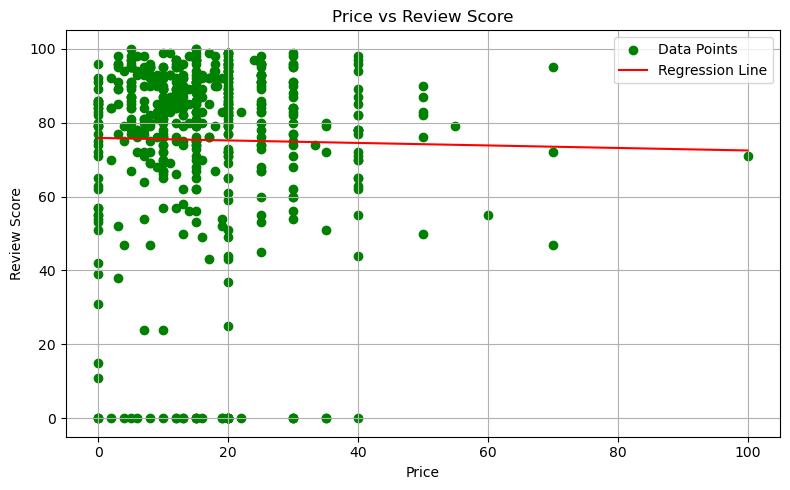

In [168]:
plt.figure(figsize=(8, 5))
plt.scatter(revenue_df['price'], revenue_df['review_score'], marker='o', color='green', label='Data Points')


slope, intercept = np.polyfit(revenue_df['price'], revenue_df['review_score'], 1)
reg_line = slope * revenue_df['price'] + intercept
plt.plot(revenue_df['price'], reg_line, color='red', label='Regression Line')


plt.xlabel("Price")
plt.ylabel("Review Score")
plt.title("Price vs Review Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

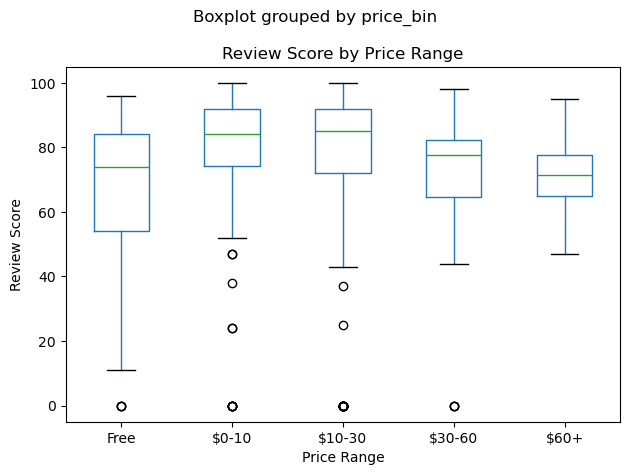

In [174]:
revenue_df['price_bin'] = pd.cut(revenue_df['price'], bins=[-0.01, 0, 10, 30, 60, 100], 
                         labels=["Free", "$0-10", "$10-30", "$30-60", "$60+"])


plt.figure(figsize=(8, 5))
revenue_df.boxplot(column='review_score', by='price_bin', grid=False)
plt.title("Review Score by Price Range") 
plt.xlabel("Price Range")
plt.ylabel("Review Score")
plt.tight_layout()
plt.show()

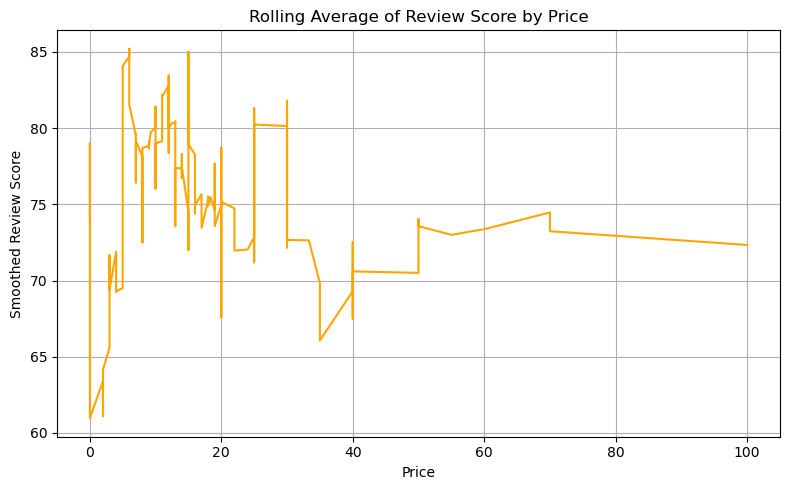

In [ ]:
df_sorted = revenue_df.sort_values('price')
df_sorted['rolling_score'] = df_sorted['review_score'].rolling(window=30, min_periods=1).mean()


plt.figure(figsize=(8, 5))
plt.plot(df_sorted['price'], df_sorted['rolling_score'], color='orange')
plt.xlabel("Price")
plt.ylabel("Smoothed Review Score")
plt.title("Rolling Average of Review Score by Price")
plt.grid(True)
plt.tight_layout()
plt.show()

What is the average revenue per publisher?

In [71]:
avg_revenue_by_pub=revenue_df.groupby('publishers')['revenue'].mean().reset_index()
avg_revenue_by_pub.head()

,publishers,revenue
0,0 Deer Soft Partnership,3.769600e+04
1,072 Project,1.588864e+05
2,101XP,1.079320e+05
3,11 bit studios,1.135672e+06
4,"14 Hours Productions,Astrolabe Games",5.788000e+04


Who is the highest grossing Publisher? 

In [72]:
highest_gross_pub=revenue_df['publishers'].max()
highest_gross_pub

'雷鸣工作室'

How do free vs paid games compare in revenue, copies sold, average playtime, and review score?

In [107]:
revenue_df['price_type'] = revenue_df['price'].apply(lambda x: 'Free' if x == 0 else 'Paid')
revenue_df['copies_sold'] = pd.to_numeric(revenue_df['copies_sold'], errors='coerce')

In [108]:
revenue_df.dtypes

id                   int64
name                object
release_date        object
copies_sold          int64
price              float64
revenue            float64
avg_playtime       float64
review_score         int64
publisher_class     object
publishers          object
developers          object
steam_id             int64
price_type          object
dtype: object

In [113]:
free_paid_grouped = revenue_df.groupby('price_type')[['revenue', 'copies_sold', 'avg_playtime', 'review_score']].mean().reset_index()


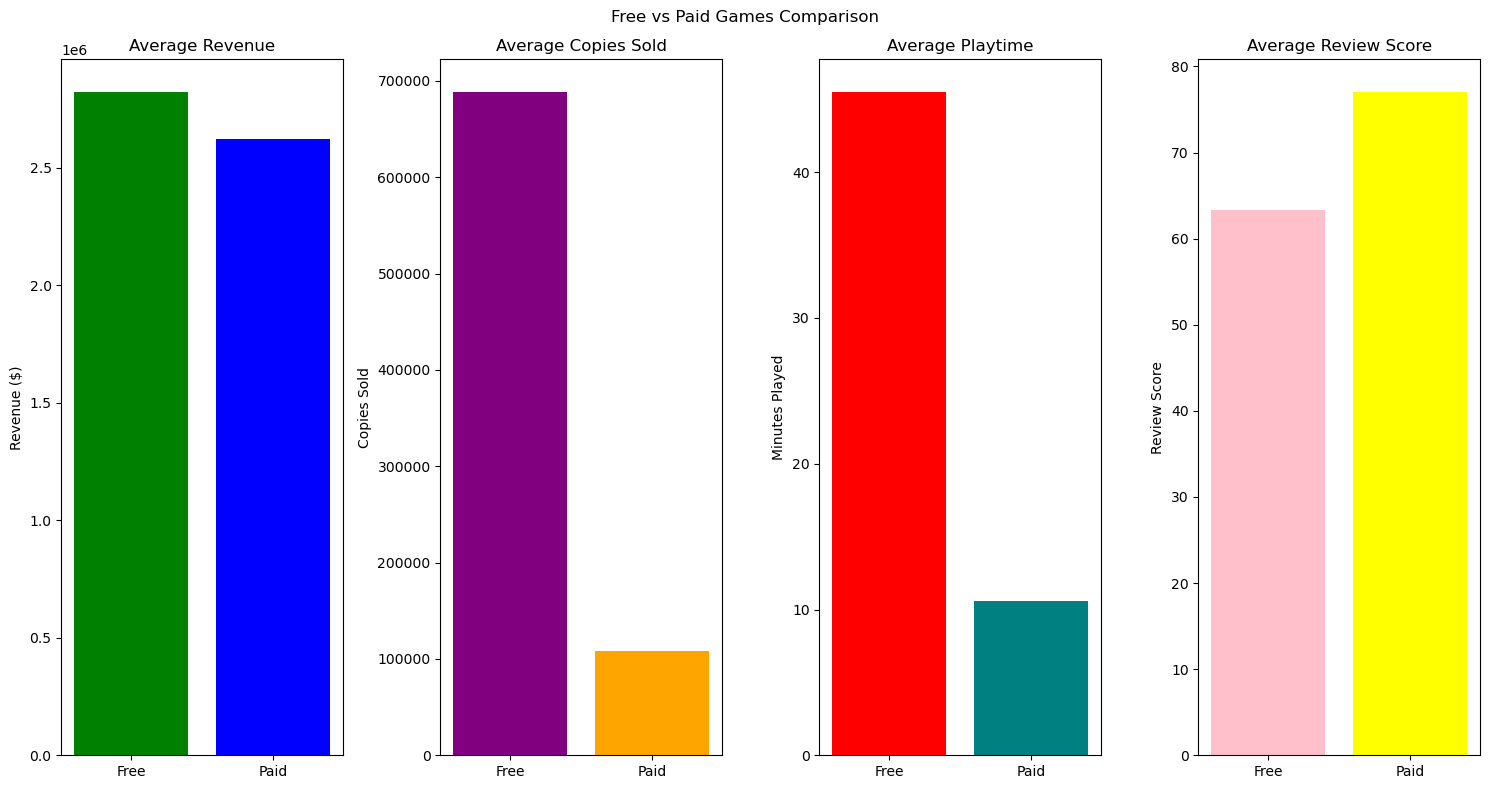

In [118]:
fig, axs = plt.subplots(1, 4, figsize=(15, 8))

# Revenue
axs[0].bar(free_paid_grouped['price_type'], free_paid_grouped['revenue'], color=['green', 'blue'])
axs[0].set_title("Average Revenue")
axs[0].set_ylabel("Revenue ($)")

# Copies Sold
axs[1].bar(free_paid_grouped['price_type'], free_paid_grouped['copies_sold'], color=['purple', 'orange'])
axs[1].set_title("Average Copies Sold")
axs[1].set_ylabel("Copies Sold")

# Playtime
axs[2].bar(free_paid_grouped['price_type'], free_paid_grouped['avg_playtime'], color=['red', 'teal'])
axs[2].set_title("Average Playtime")
axs[2].set_ylabel("Minutes Played")

# Review Score
axs[3].bar(free_paid_grouped['price_type'], free_paid_grouped['review_score'], color=['pink', 'yellow'])
axs[3].set_title("Average Review Score")
axs[3].set_ylabel("Review Score")

plt.suptitle("Free vs Paid Games Comparison")
plt.tight_layout()
plt.show()

What is the average revenue trend throughout the year?

In [161]:
revenue_df['release_date'] = pd.to_datetime(revenue_df['release_date'], errors='coerce')
revenue_df['release_month'] = revenue_df['release_date'].dt.month

revenue_df = revenue_df[revenue_df['release_month'].notna() & revenue_df['revenue'].notna()]
revenue_df = revenue_df[~revenue_df['revenue'].isin([float('inf'), float('-inf')])]
revenue_df['release_month'] = revenue_df['release_month'].astype('int64')

monthly_revenue = revenue_df.groupby('release_month')['revenue'].mean().reset_index()

In [162]:
revenue_df.dtypes

id                          int64
name                       object
release_date       datetime64[ns]
copies_sold                 int64
price                     float64
revenue                   float64
avg_playtime              float64
review_score                int64
publisher_class            object
publishers                 object
developers                 object
steam_id                    int64
price_type                 object
release_year              float64
release_month               int64
dtype: object

In [163]:
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_revenue['month_name'] = monthly_revenue['release_month'].apply(lambda x: month_labels[x - 1])

monthly_revenue = monthly_revenue.sort_values('release_month')

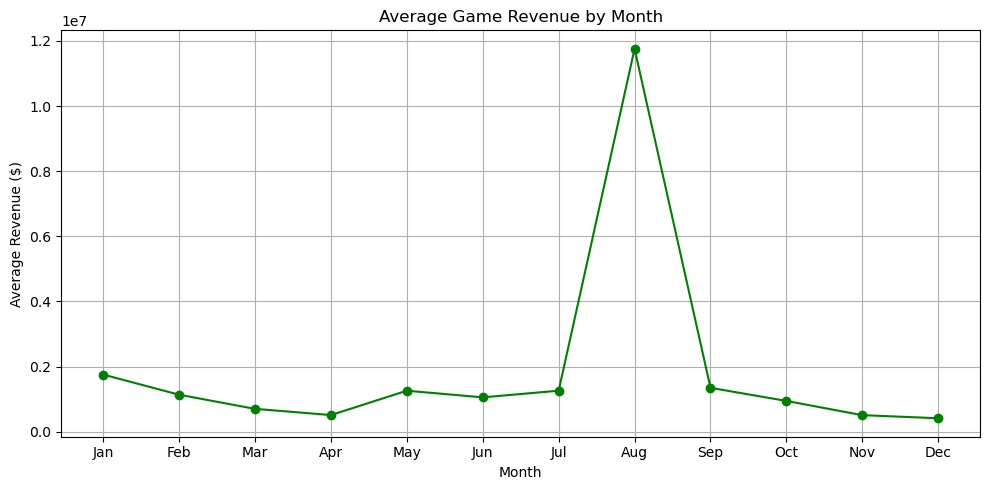

In [164]:
plt.figure(figsize=(10, 5))
plt.plot(monthly_revenue['month_name'], monthly_revenue['revenue'], marker='o', color='green')
plt.title('Average Game Revenue by Month')
plt.xlabel('Month')
plt.ylabel('Average Revenue ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

Do games with higher average playtime generate more revenue?

In [176]:
revenue_df = revenue_df[(revenue_df['avg_playtime'] > 0) & (revenue_df['revenue'] > 0)]
correlation = revenue_df['avg_playtime'].corr(revenue_df['revenue'])

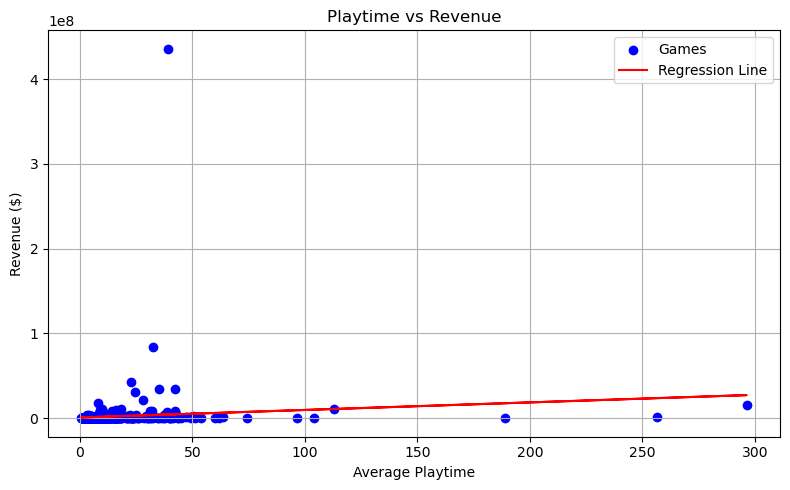

In [181]:
plt.figure(figsize=(8, 5))
plt.scatter(revenue_df['avg_playtime'], revenue_df['revenue'], marker='o', color='blue', label='Games')


slope, intercept = np.polyfit(revenue_df['avg_playtime'], revenue_df['revenue'], 1)
plt.plot(revenue_df['avg_playtime'], slope * revenue_df['avg_playtime'] + intercept, color='red', label='Regression Line')


plt.xlabel("Average Playtime")
plt.ylabel("Revenue ($)")
plt.title("Playtime vs Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()